# Import Libraries


In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
numb_batch = 64

# Getting Data

In [3]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)



Failed to download (trying next):
HTTP Error 403: Forbidden



1.0%

100.0%


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



# plotting a data Sample

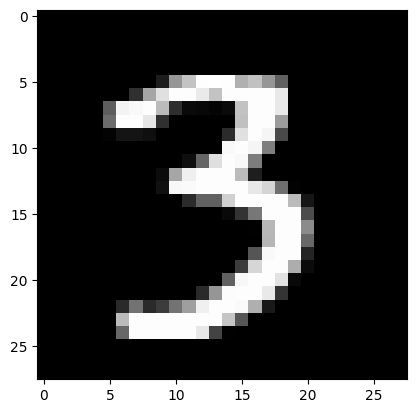

In [12]:
index = 10000

data, target = train_data[index]

# Plot the data
plt.imshow(data.squeeze(), cmap = 'gray')
plt.show()

# Creating the Model

In [13]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        nn.Flatten(),
        nn.Linear(400, 120),

        nn.ReLU(),
        nn.Linear(120, 84),

        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

#Validating Model

In [14]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

# Training Function

In [15]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

#GPU Availability

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

No Cuda Available


device(type='cpu')

# Training the Model

In [17]:
lenet = train(numb_epoch=20, device = device)

AssertionError: Torch not compiled with CUDA enabled

# Creating a Function to Test Validation Data

In [ ]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

# Confusion Matrix

In [ ]:
y_pred, y_true = predict_dl(lenet, val_dl)

pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,0,1,2,0
1,0,1133,0,0,0,2,0,0,0,0
2,1,1,1025,0,1,0,0,2,2,0
3,0,0,4,997,0,3,0,3,0,3
4,0,0,1,0,972,0,5,0,0,4
5,2,0,0,5,0,879,2,1,1,2
6,3,3,0,0,0,7,944,0,1,0
7,0,5,5,0,0,0,0,1015,1,2
8,2,0,4,1,1,2,0,2,960,2
9,0,3,0,0,5,3,0,6,2,990
